# Relax and hold steady

## Stokes flow

This notebook presents the coding assignment for **Module 5** of the course [*"Practical Numerical Methods with Python.*](https://github.com/numerical-mooc/numerical-mooc) Your mission is to solve Stokes flow in a square cavity, using the vorticity-streamfunction formulation.
Stokes flow, also known as *creeping flow*, refers to flows that are dominated by viscous forces and not by the advective/convective forces.  The Stokes-flow assumption works well for flows that have very low Reynolds number, much smaller than 1: very slow, highly viscous or flows at microscopic length scales.  

Stokes flow allows us to simplify the Navier-Stokes equations, eliminating the non-linearity.  Let's run through a quick derivation of the vorticity-transport equation with Stokes-flow assumptions.  

### Vorticity

We start with the Navier-Stokes equations for incompressible flow:

\begin{equation}
\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho}\nabla p + \nu\nabla^2 u
\end{equation}

If we scale Equation $(1)$ to make it non-dimensional, we can rewrite it as

\begin{equation}
Re \left(\frac{\partial u^*}{\partial t} + u^* \cdot \nabla u^* \right) = -\nabla p^* + \nabla^2 u^*
\end{equation}

Where $u^*$ and $p^*$ are the non-dimensional velocity and pressure, respectively.  

To obtain Stokes flow, we assume that the Reynolds number approaches zero.  Applying that assumption to Equation $(2)$ and dropping the stars, yields

\begin{equation}
0 = - \nabla p + \nabla^2 u
\end{equation}

That simplified things!  Now, we apply the curl operator on both sides of the equation:

\begin{equation}
\nabla \times 0 = \nabla \times \left( - \nabla p + \nabla^2 u\right)
\end{equation}

The left-hand side remains zero, while the first term on the right-hand side is

\begin{equation}
\nabla \times - \nabla p = 0
\end{equation}

because $\nabla \times \nabla \phi = 0$ where $\phi$ is a scalar.

Finally,

\begin{equation}
\nabla \times \nabla^2 u =\nabla^2\omega
\end{equation}

where $\nabla \times u = \omega$ is the vorticity.  

Combining all of these equations, we arrive at the simplified vorticity transport equation for Stokes flow:

\begin{equation}
\nabla ^2 \omega = 0
\end{equation}

Look familiar?

### Stream function

Define the stream function $\psi$, such that

\begin{equation}
u = \frac{\partial \psi}{\partial y} \text{   and   } v = - \frac{\partial \psi}{\partial x}
\end{equation}

In 2D, we can write out the vorticity as

\begin{equation}
\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation}

which, combined with the previous equation yields another familiar looking equation:

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

We have a system of two coupled equations that can describe the fluid flow in a lid-driven cavity at very low Reynolds numbers.  

\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

Note that by substituting Equation $(12)$ into $(11)$, we arrive at a new equation: the *biharmonic equation*:

\begin{equation}
\nabla^4 \psi= 0
\end{equation}

### Solving the biharmonic equation

Is it possible to discretize a 4th-order partial differential equation?  Of course!  Are we going to?  No!

There's nothing wrong with a 4th-order equation, but in this course module we learned about the Poisson equation and that's what we're going to use.  

## Cavity flow

You will solve a problem called *lid-driven cavity flow*.  This is a common test problem for Navier-Stokes solvers—we'll be using it to examine Stokes flow.  

Assume that the lid of a square cavity moves at a constant velocity of $u=1$, with no fluid leaking out past the moving lid. We we want to visualize what the flow field inside the cavity looks like at steady state.  

All of the surfaces, including the lid, are assumed to have no-slip boundary conditions.  The boundary conditions are all specified in terms of the streamfunction $\psi$, as shown below in Figure $(1)$.  

<img src="./figures/drivencavity.svg" width=400px>

#### Figure 1. Lid-driven Cavity Flow

### Boundary conditions

One of the major hurdles with the vorticity-streamfunction formulation is the treatment of boundary conditions.  

The boundary conditions are all specified in terms of $\psi$ and its derivatives, but the Laplace equation

$$\nabla \omega^2 = 0$$

has no $\psi$ value.  Instead, we need a way to represent the boundary conditions for $\omega$ in terms of $\psi$.  

Consider the equation $\nabla ^2 \psi = -\omega$ along the top surface of the cavity (the moving surface).  There can't be any velocity in the $y$-direction because the surface is solid, so $\frac{\partial ^2 \psi}{\partial x^2}$ goes to zero and the equation simplifies to

\begin{equation}
\frac{\partial ^2 \psi}{\partial y^2} = -\omega
\end{equation}

A 2nd-order central difference discretization gives

\begin{equation}
\omega_j = - \left(\frac{\psi_{j+1} - 2\psi_j + \psi_{j-1}}{\Delta y^2}\right)
\end{equation}

but the value $\psi_{j+1}$ is outside of the domain.  Now take a 3rd-order discretization of $\frac{\partial \psi}{\partial y}$ evaluated along the top edge.

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = \frac{2\psi_{j+1} + 3\psi_j - 6\psi_{j-1} + \psi_{j-2}}{6 \Delta y}
\end{equation}

$\frac{\partial \psi}{\partial y}$ is a given boundary value in the problem along the top edge

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = u_j
\end{equation}

which leaves us with a value for $\psi_{j+1}$ that consists only of points within the domain.  

\begin{equation}
\psi_{j+1} = \frac{6\Delta y u_j - 3\psi_j + 6 \psi_{j-1} - \psi_{j-2}}{2}
\end{equation}

Plug in that result into the initial discretization from Equation $(16)$ and we have a boundary condition for $\omega$ along the top surface in terms of $\psi$:

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - \psi_{i, j-2}) - \frac{3u_j}{\Delta y} + \mathcal{O}(\Delta y^2)
\end{equation}

### Coding assignment

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from laplace_helper import L2_rel_error

Solve Stokes flow in a lid-driven cavity using the parameters given below.  

You should iteratively solve for both $\omega$ and $\psi$ until the L1 norm of the difference between successive iterations is less than $1$$\tt{E}$$^-6$ for **both** quantities.  

### Parameters and Initial Conditions

In [29]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6
l2_target = 1e-6


# Initialization
omega  = numpy.zeros((ny,nx))
psi  = numpy.zeros((ny,nx))
U_top  = numpy.ones((ny-3))
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)
psi[-2,:] = 1

### Plot initial conditions

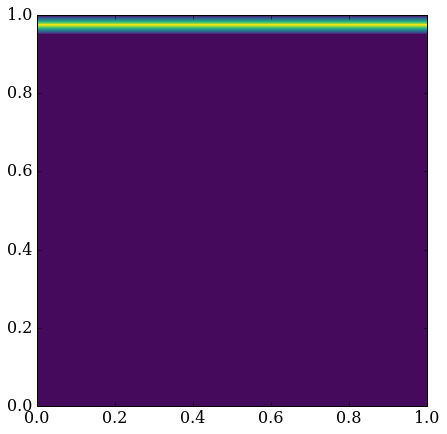

In [30]:
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,psi,20, cmap=cm.viridis);



### Helper Functions

#### L1_norm

In [31]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

#### L2_error

In [32]:
def L2_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

#### Laplace_2d

In [33]:
def laplace2d(p, psi, l2_target):
    '''Iteratively solves the Laplace equation using the Jacobi method
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    l2_target: float
        target for the difference between consecutive solutions
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])

        # update velocity
        U_top = (psi[-2,:] - psi[-1,:]) /(dy)
        U_bottom = (psi[1,:] - psi[0,:]) /(dy)
        U_left = (psi[:,-2] - psi[:,-1]) /(dy)
        U_right = (psi[:,1] - psi[:,0]) /(dy)

        
        # Apply Neumann BC to omega
        p[-1,2:-1] = (1/2*dy**2) * (8*psi[-1,1:-2] - psi[-1,:-3]) #- 3*(U_top[2:-1]+1) / dy
        p[0,2:-1] = (1/2*dy**2) * (8*psi[0,1:-2] - psi[0,:-3]) #- 3*U_bottom[2:-1] / dy
        #p[2:-1,0] = (1/2*dy**2) * (8*psi[1:-2,0] - psi[:-3,0]) #- 3*U_left[2:-1] / dx
        #p[2:-1,-1] = (1/2*dy**2) * (8*psi[1:-2,-1] - psi[:-3,-1]) #- 3*U_right[2:-1] / dx
        
        l2norm = L2_error(p, pn)
     
    return p

#### Poisson_2d (Jacobi)

In [34]:
def poisson_2d(omega, psi, dx, dy, l1_target):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    omega : 2D array of floats
        Vorticity
    psi : 2D array of floats
        Stream function
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    omega: 2D array of float
        Distribution after relaxation
    psi: 2D array of float
        Distribution after relaxation    
    '''

    l1_norm = 1
    iterations = 0
    l1_conv = []
    
    omega_old = omega.copy()
    
    while l1_norm > l1_target:
        
        # compute Psi
        psi_d = psi.copy()
        
        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi_d[1:-1,2:] + psi_d[1:-1,:-2])*dy**2 +\
                        (psi_d[2:,1:-1] + psi_d[:-2,1:-1])*dx**2 -\
                         omega[1:-1,1:-1])
        
        # Dirichlet BCs
        psi[0,:] = 0    #psi[1,:]
        psi[-1,:] = 0   #psi[-2,:] + 1
        psi[:,0] = 0    #psi[:,1]
        psi[:,-1] = 0   #psi[:,-2]
        
        # computr Omega
        omega = laplace2d(omega.copy(), psi.copy(), l2_target)
        
        # complute L1 norm
        l1_norm = L1norm(psi,psi_d)
        
        iterations += 1
        l1_conv.append(l1_norm)
        
    print('Number of Jacobi iterations: {0:d}'.format(iterations))
    return omega, psi, l1_conv   

### Run Simulation

In [35]:
# compute psi
omega, psi, l2_conv = poisson_2d(psi.copy(), omega.copy(), dx, dy, l1_target)

 

Number of Jacobi iterations: 6525


### Plot Result

max omega:  1.0
max psi:  310.364845989
[   0.     -276.1066 -257.9635 -257.9635 -276.1066    0.    ]


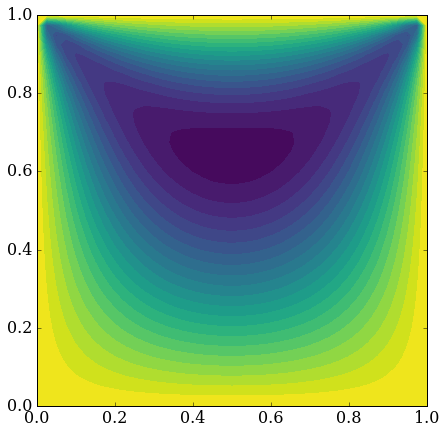

In [36]:
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,psi,20, cmap=cm.viridis);
print('max omega: ', numpy.amax(numpy.abs(omega)))
print('max psi: ', numpy.amax(numpy.abs(psi)))

print(numpy.round(psi[32,::8], 4)) 

The final result should resemble the plot shown in Figure $(2)$.

##### Hint

The boundary conditions for $\omega$ depend upon the current value of $\psi$.  The two equations are *coupled*.  If you try to solve them in a *uncoupled* way, things will go poorly.  

<img src="./figures/stokes_contour.svg">

#### Figure 2.  Contour plot of streamfunction at steady state

### References

*  Fletcher, C. A. (1988). Computational Techniques for Fluid Dynamics: Volume 2: Specific Techniques for Different Flow Categories.

*  Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method. Journal of computational physics, 48(3), 387-411.

* Greenspan, D. (1974). Discrete numerical methods in physics and engineering (Vol. 312). New York: Academic Press.

* Heil, Matthias (2007).  [Viscous Fluid Flow Vorticity Handout (pdf)](http://www.maths.manchester.ac.uk/~mheil/Lectures/Fluids/Material_2007/Vorticity.pdf)

* Non-dimensionalization and scaling of the Navier Stokes equations.  (n.d.). In *Wikipedia*.  Retrieved January 30, 2015 [http://en.wikipedia.org/w/index.php?title=Non-dimensionalization_and_scaling_of_the_Navier-Stokes_equations](http://en.wikipedia.org/w/index.php?title=Non-dimensionalization_and_scaling_of_the_Navier%E2%80%93Stokes_equations&oldid=641860920)

In [ ]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())